In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import scipy.stats as sc
import QuantLib as ql
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Alignment
from openpyxl.styles import numbers
from openpyxl.styles.borders import Border, Side
from openpyxl.styles import Font, Color, colors, PatternFill
import matplotlib.pyplot as plt

c:\Users\Come5\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Come5\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\Come5\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


<h1 style="text-align: center;">Construction de Stress Tests</h1>

Après avoir dréssé un état des lieux des grandes méthodes de stress testing d'un portefeuille d'actifs, nous verrons comment il est possible d'implémenter certaines méthodes avec Python.

Les exemples traités constituent des démonstrations simplistes. Dans la réalités, les institutions financières utilisent des outils propriétaires ou des progiciels qui ont été développés par des équipes entières de développeurs, d'actuaires et de financiers. D'ailleurs, l'application réelle de ces méthodes, au sein de ces institutions, est souvent faite de façon collégiale avec concertation entre les équipes de risque (souvent des actuaires), les équipes financières (investissements, direction comptable et financière) et la direction générale de l'entreprise. Cela s'explique par le fait que ces travaux peuvent avoir des impacts important sur la stratégie d'une entreprise (à cause de sa solvabilité et du coût des fonds propres).

#### Qu'est ce qu'un stress test ?

Les stress tests permettent de créer des situations "artificielles" applicables à un portefeuille existant, pour en mesurer le comportement lors de large chocs de marché. Ils permettent de répondre à deux questions importantes des entreprises financières :
- Combien je pourrais perdre si le scénario X venait à se produire ?
- Quel évènement pourrait me conduire à perdre X millions d'euros (ou % de la valeur de mon portefeuille) ?

Ces questions se posent à différents niveaux dans une institution financière. Par exemple, la direction générale d'une institution financière va adopter une approche "top-down" pour essayer de mesurer le degré de perte qu'elle pourrait subir en cas de rupture du marché des actions, notamment pour répondre à des contraintes ALM. Au niveau du business, ce type d'outil peut-être utilisé pour des objectifs de couverture, de pricing ou d'allocation d'actifs.

Il existe différentes approches pour stresser un portefeuille d'actifs, qui sont résumées ci-dessous :
- Les scénarios historiques
- Les scénarios hypothétiques
- Les stress tests algorithmiques 

#### Scénarios historiques

Ils permettent de quantifier les pertes potentiels en rejouant des moments particuliers de l'histoire des marchés qui ont eu des effets significatifs sur les classes d'actifs. Cette méthode est requise par le Comité de Bâles : 

>scenarios could include testing the current portfolio against past periods of significant disturbance, for example, the 1987 equity crash, the ERM crises of 1992 and 1993 or the fall in bond markets in the first quarter of 1994, incorporating both the large price movements and the sharp reduction in liquidity associated with these events’ (Basel Committee on Banking Supervision, 1996).

L'utilisation des scénarios historiques requiert de choisir des périodes de l'histoire où les marchés étaient en crise, et d'appliquer au portefeuille actuel les mêmes stress que ceux qui ont eu lieu à ces moments-là. Il s'agira alors de mesurer le niveau de pertes du portefeuille issues de ces chocs. 
Cette méthode pose cependant le problème de la sélection des différentes périodes de l'histoire. Il existe 2 grandes méthodes de sélection :

1. on utilise des crises bien connues et bien identifées, e.g la crise asiatique de 1997 ;
2. on définit des seuils sur des classes d'actifs. Cette seconde méthode devrait faire apparaître les grandes crises, mais également d'autres périodes, surtout si l'analyse est faite sur des facteurs de risque spécifiques.

La première méthode est la plus répandue dans le marché, et les grandes crises qui reviennent souvent sont :

- Le crack des actions US en 1987
- La crise des taux de change européens en 1992
- Le sell-off des obligations américaines en 1994
- La crise du peso mexicain en 1994
- La crise asiatique en 1997
- Le défaut Russe en 1998
- La chûte de LTCM et la crise de liquidité en 1998
- Les attaques du 11 septembre 2001
- La crise de 2007 (qui a démarré à l'été 2007)
- Crises des dettes souveraines en Europe (Avril 2011 - Novembre 2011)
- Referendum pour le Brexit (Juin 2016)
- Spike de Volatilité (Septembre 2018 - Decembre 2018)
- Covid 19 (Fevrier 2020 - Mars 2020)
- Hausse des taux 2022 (Janvier 2022 - Septembre 2022)

> Un profilage systématique des crises est nécessaire pour être utile à cet exercice. Mais ce profilage est un exercice compliqué.

- Quelles dates de début et de fin ?
- Quels taux ou niveaux de marchés initiaux et finaux ?
- Est ce que cette crise touche toutes les classes d'actifs ? Si ce n'est pas le cas, est ce véritablement une crise ?

Pour cela, il faut dans un premier temps s'assurer que la période choisie capte les plus grands évènements de la crise.

Pour les variations, il est possible d'utiliser les pires variations à travers une analyse de drawdown, et d'utiliser les plus importantes dans nos stress tests. Mais se faisant, on risque d'obtenir des résultats qui n'ont plus de sens économique.

De plus, on peut rencontrer des défis techniques :
Comment prendre en compte les actifs qui sont sensibles au passage du temps (dérivés, obligations, futures, forwards) ?

- Soit on part du principe que le choc a lieu sur un jour de trading, et on ne traite pas le sujet du passage du temps ;
- Soit on intègre le passage du temps dans la modélisation, cela qui complexifie grandement la tâche, mais donne des résultats plus réalistes.

Les chocs peuvent être appliqués en valeur relative (en taux de variation) ou en valeur absolue (le taux de change EUR USD est passé de 1.09 à 1.0) :

Pour faciliter l'analyse il est recommandé d'utiliser les variations relatives, cependant ce n'est pas toujours possible (les chocs sur les taux doivent être exprimés en valeur absolue). En revanche, les chocs de volatilité devraient être exprimés en taux de variation, car la volatilité ne peut pas être négative.

Appliquer des chocs d'intérêt à des courbes de taux actuelles est un exercice difficile et doit faire l'objet de nombreuses attentions car :

- La recherche a montré que 3 facteurs expliquent 95% des mouvements des courbes de taux (le niveau des taux, l'ordonnée à l'origine et la courbe). C'est un choc sur ces 3 points qui devrait être appliqué car si on applique simplement un choc de taux à chaque points de la courbe, cette dernière pourrait avoir une forme non réaliste. Ce raisonnement est valable pour tous les actifs qui ont une "term structure", tels que la volatilité, les taux de change, et les commodities (futures).

L'utilisation de données historiques est problématique lorsqu'on souhaite étudier le comportement d'une classe d'actifs qui n'existait pas durant les crises financières du passé e.g les cryptos. De plus, des données trop vieilles pourraient ne pas être fiables. Dans ce cas là, il est nécessaire de mettre en place une politique de gestion des effets de bords :

Plusieurs outils sont utiles pour ce problème :
- Un proxy : on utilise le choc d'un actif qui a un comportement proche de celui dont on a pas la donnée ou une donnée de mauvaise qualité. Il est également possible d'utiliser plusieurs proxy.
- L'interpolation ou l'extrapolation : c'est surtout utile pour les actifs obligataires. Par exemple, étant donné la corrélation qui existe entre les différents tenor d'un produit ayant une term structure, il est facile d'extrapoler linéairement les points adjacent d'un tenor.

>Pour être efficace et mettre en lumière des vulnérabilités, il faut bien sûr inclure et tester plusieurs scénarios, diversifiés entre eux.

#### Scénarios hypothétiques

Bien qu'il y ait de plus en plus de crises sur les marchés financiers, nous n'avons pas l'assurance que les chocs passés puissent couvrir l'exhaustivité des chocs qui pourraient avoir lieu dans le future, c'est pourquoi il peut-être intéressant de créer des scénarios économiques, à l'aide de modèles capable de capturer les interdépendances entre les différents marchés.

Cependant c'est un exercice très complexe qui nécessite de considérer les résultats avec beaucoup de précautions.

##### 1. Modéliser la matrice de covariance

Dans ces travaux, la matrice de Covariance est très importante car elle va traduire ce phénomène de crise à travers des changement d'états structuraux. En effet, de nombreuses études ont montré que lors des phases de crise, les classes d'actifs avaient tendance à se recorréler.

Cela s'explique par les comportements suivants :
- Lors des crises, les investisseurs sont nerveux ont tendance à effectuer des ordres de vente sans distinction entre les actifs pour être sûr de se désensibiliser aux marchés. Lorsque ce comportement est pratiqué par de nombreux opérateurs de marchés, alors cela peut conduire toute une classe d'actifs dans la même direction.
- Cela peut aussi se manifester lorsque les actions d'un agent contraint les actions d'un autre. Ce phénomène d'interdépendance peut se retrouver dans la gestion d'un fonds ou la sortie de petits porteurs pourraient entraîner la sortie d'un plus gros, car les ratios d'emprise sont dépassés. Cette situation pourrait conduire à une survente d'une classe d'actifs.
- Ce phénomène peut aussi de manifester lorsqu'un agent, confronté à une crise de liquidité sur un marché, tente de liquidité des positions sur d'autres marchés, précipitant une crise de liquidité dans tout le système.

>Mais la modélisation de la matrice de Covariance n'est pas chose aisée, et il est déconseillé de changer arbitrairement des corrélations, au risque de produire des rendements de portefeuilles stressés improbables. Lorsqu'on souhaite changer des éléments dans la matrice de corrélation, il est nécessaire de suivre certaines règles.

Pour contrôler l'impact des changements que l'on souhaite obtenir sur la matrice de covariance/corrélation, il vaut mieux appliquer un ajustement sur le vecteur de rendement d'un facteur de risque. Ainsi, il est possible de modifier les vecteurs de rendement des facteurs de risque dont les corrélations doivent être modifiées de telle sorte que le rendement de chaque facteur un jour t, soit une combinaison linéaire du rendement historiquement observé de ce facteur le jour t et de la moyenne des rendements sur les facteurs de marché affectés au jour t. Il est également possible de "stresser" des variances individuelles.

Dans son article Finger (Finger, C (1997)  A methodology to stress correlations. RiskMetrics Monitor, 3-12.) propose d'utiliser la méthodologie suivante :

il faut trouver $\theta$, qui est une combinaison linéaire des deux titres, qui minimise l'erreur de corrélation entre deux titres avec une cible :

${E}(\theta) = (\rho_{ij} - \rho_{ij}^*)^2$

où $\rho_{ij}$ est estimé en utilisant la nouvelle combinaison linéaire de rendements :

$R_{mod}^a = \theta \frac{R^a + R^b}{2} + (1 - \theta) R^a$ avec $R_{mod}^a = \frac{\sigma_{R^a}}{\sigma_{R_{mod}^a}}$ (cette dernière opération permettant de normaliser les rendements)

$R_{mod}^b = \theta \frac{R^a + R^b}{2} + (1 - \theta) R^b$ avec $R_{mod}^b = \frac{\sigma_{R^b}}{\sigma_{R_{mod}^b}}$


Décomposons les fonctions construites pour répondre à cette problématique :

In [6]:
def theta_returns(theta, returns_x, returns_y):  
    mod_returns_x = theta * (returns_x + returns_y)/2 + (1 - theta) * returns_x
    mod_returns_y = theta * (returns_x + returns_y)/2 + (1 - theta) * returns_y
    
    mod_returns_x = mod_returns_x * (returns_x.std() / mod_returns_x.std())
    mod_returns_y = mod_returns_y * (returns_y.std() / mod_returns_y.std())
    
    return mod_returns_x, mod_returns_y

La fonction _theta_returns_ permet de transformer les séries temporelles initiales de rendements, en rendements modifiées, selon la méthode fournies par Finger. En changeant le paramètre theta, on produit des séries différentes à partir desquelles nous allons estimer des corrélations.

In [7]:
def pairwise_correlation(theta, returns_x, returns_y, target_corr):
    mod_returns_x, mod_returns_y = theta_returns(theta, returns_x, returns_y)
    corr = np.corrcoef(mod_returns_x, mod_returns_y)[0][1]
    return (corr - target_corr)**2

La fonction _pairwise_correlation_ permet de mesurer le degré de correlation entre deux séries temporelles. C'est notre fonction objective, à partir de laquelle on va mesurer le degré d'erreur de correlation entre deux séries de rendements modifiées à l'aide du paramètre $\theta$.

In [8]:
def find_theta(returns, var_x, var_y, target_corr):
    TOLERANCE = 1e-15
    
    solution = minimize(
        fun=pairwise_correlation, 
        x0=.5, 
        args=(returns[var_x], returns[var_y], target_corr), 
        method='SLSQP', 
        tol=TOLERANCE)
    
    return solution.x.round(6)

La fonction _find_theta_ implémente le programme d'optimisation (minimisation de l'erreur de correlation) qui permettra d'obtenir le paramètre $\theta$ qui permet à nos séries de rendements modifiés d'avoir une corrélation égale à la corrélation cible.

***Extraction des données***

In [9]:
MY_PATH = "C:\\Users\\Come5\\SynoCome\\AVerley\\PRIVATE\\NoteBook\\equity_index.xlsx"
prices = pd.read_excel(MY_PATH, header=0, index_col=0, parse_dates=True)
daily_returns = np.log(prices).diff().dropna()

In [6]:
NUM_DAYS = 500
historical_corr = daily_returns.tail(NUM_DAYS).corr()
print(historical_corr)

           GSPC.INDX  SX5E.INDX  N225.INDX    EEM.US   GC.COMM
GSPC.INDX   1.000000   0.542759   0.166429  0.685555  0.076254
SX5E.INDX   0.542759   1.000000   0.240654  0.587003  0.027020
N225.INDX   0.166429   0.240654   1.000000  0.187266  0.023536
EEM.US      0.685555   0.587003   0.187266  1.000000  0.205724
GC.COMM     0.076254   0.027020   0.023536  0.205724  1.000000


Lorsqu'on regarde cette matrice de corrélation, on peut voir par exemple que la ***corrélation entre l'Eurostoxx 50 et le S&P 500 est de 56%*** (sur 500 jours, à partir de rendements quotidiens).

Nous allons essayer d'etimer le paramètre $\theta$, qui appliqué à nos séries temporelles, permet de produire des vecteurs de rendements dont la corrélation est égale à 85%. 

In [7]:
my_theta = find_theta(daily_returns.tail(NUM_DAYS), "GSPC.INDX", "SX5E.INDX", 0.85)
print(f"Theta (GSPC, SX5E) : {my_theta[0]:.3}")

Theta (GSPC, SX5E) : 0.477


Observons l'impact de cette transformation sur nos séries de rendements :

In [8]:
gspc_mod, sx5e_mod = theta_returns(my_theta[0], daily_returns.tail(NUM_DAYS)["GSPC.INDX"], daily_returns.tail(NUM_DAYS)["SX5E.INDX"])

hist_corr = np.corrcoef(daily_returns.tail(NUM_DAYS)["GSPC.INDX"], daily_returns.tail(NUM_DAYS)["SX5E.INDX"])[0][1]
stress_corr = np.corrcoef(gspc_mod, sx5e_mod)[0][1]

print("*** S&P 500 ***")
print(f'Moyenne / Ecart type sur les rendements historiques : {daily_returns.tail(NUM_DAYS)["GSPC.INDX"].mean():.2%} / {daily_returns.tail(NUM_DAYS)["GSPC.INDX"].std():.2%}')
print(f'Moyenne / Ecart type sur les rendements modifiés : {gspc_mod.mean():.2%} / {gspc_mod.std():.2%}')
print("\n")
print("*** EUROSTOXX 50 ***")
print(f'Moyenne / Ecart type sur les rendements historiques : {daily_returns.tail(NUM_DAYS)["SX5E.INDX"].mean():.2%} / {daily_returns.tail(NUM_DAYS)["SX5E.INDX"].std():.2%}')
print(f'Moyenne / Ecart type sur les rendements modifiés : {sx5e_mod.mean():.2%} / {sx5e_mod.std():.2%}')
print("\n")
print("*** CORRELATIONS ***")
print(f"Corrélation historique : {hist_corr:.1%} / Corrélation stressée : {stress_corr:.1%}")

*** S&P 500 ***
Moyenne / Ecart type sur les rendements historiques : -0.01% / 1.24%
Moyenne / Ecart type sur les rendements modifiés : -0.00% / 1.24%


*** EUROSTOXX 50 ***
Moyenne / Ecart type sur les rendements historiques : 0.00% / 1.27%
Moyenne / Ecart type sur les rendements modifiés : 0.00% / 1.27%


*** CORRELATIONS ***
Corrélation historique : 54.3% / Corrélation stressée : 85.0%


Points saillants :
- L'optimisation a bien fonctionné et les nouvelles séries de rendements ont bien une correlation de 85%.
- Les nouvelles séries temporelles gardent une volatilité inchangée (ce qui est intéressant), seuls le rendement moyen est impacté (mais ce n'est pas significatif).

Comparons les séries de rendements.

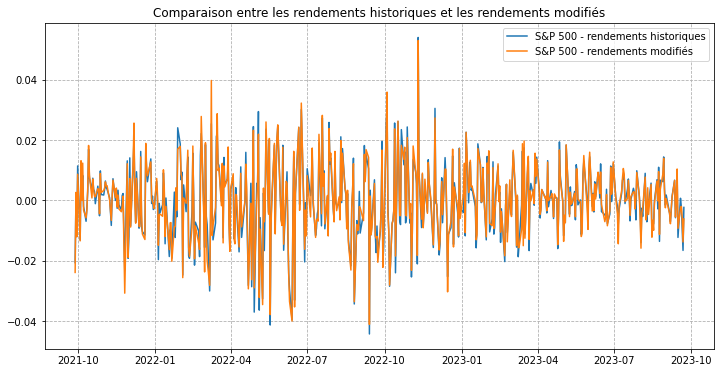

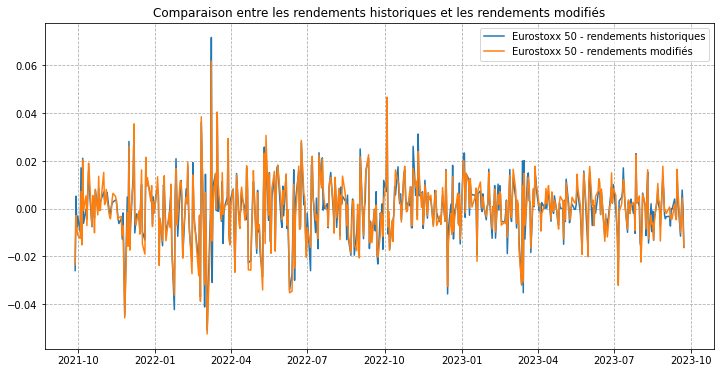

In [25]:
plt.figure(figsize=(12,6))
plt.plot(daily_returns.tail(NUM_DAYS)["GSPC.INDX"], label="S&P 500 - rendements historiques")
plt.plot(gspc_mod, label="S&P 500 - rendements modifiés")
plt.title("Comparaison entre les rendements historiques et les rendements modifiés")
plt.legend()
plt.grid(linestyle="--")

plt.figure(figsize=(12,6))
plt.plot(daily_returns.tail(NUM_DAYS)["SX5E.INDX"], label="Eurostoxx 50 - rendements historiques")
plt.plot(sx5e_mod, label="Eurostoxx 50 - rendements modifiés")
plt.title("Comparaison entre les rendements historiques et les rendements modifiés")
plt.legend()
plt.grid(linestyle="--")

Essayons maintenant de reconstruire la matrice de corrélation en integrant les nouvelles séries :

In [9]:
daily_ret = daily_returns.tail(NUM_DAYS).copy() # Creation d'un nouveau dataframe qui est une copie de daily_returns
daily_ret["GSPC.INDX"] = gspc_mod # insertion des rendements modifiés
daily_ret["SX5E.INDX"] = sx5e_mod

new_corr = daily_ret.corr()

print("*** HISTORICAL CORRELATIONS ***")
print(historical_corr)
print("\n")
print("*** STRESSED CORRELATIONS ***")
print(new_corr)

*** HISTORICAL CORRELATIONS ***
           GSPC.INDX  SX5E.INDX  N225.INDX    EEM.US   GC.COMM
GSPC.INDX   1.000000   0.542759   0.166429  0.685555  0.076254
SX5E.INDX   0.542759   1.000000   0.240654  0.587003  0.027020
N225.INDX   0.166429   0.240654   1.000000  0.187266  0.023536
EEM.US      0.685555   0.587003   0.187266  1.000000  0.205724
GC.COMM     0.076254   0.027020   0.023536  0.205724  1.000000


*** STRESSED CORRELATIONS ***
           GSPC.INDX  SX5E.INDX  N225.INDX    EEM.US   GC.COMM
GSPC.INDX   1.000000   0.850000   0.202199  0.725388  0.070507
SX5E.INDX   0.850000   1.000000   0.244190  0.667309  0.042176
N225.INDX   0.202199   0.244190   1.000000  0.187266  0.023536
EEM.US      0.725388   0.667309   0.187266  1.000000  0.205724
GC.COMM     0.070507   0.042176   0.023536  0.205724  1.000000


Sur la matrice de corrélation globale, l'effet est proche de l'effet désiré puisque la corrélation entre nos deux actifs est bien à la cible. On observe cependant des changements ailleurs que sur la paire choisie, notamment sur la correlation entre l'Eurostoxx 50 et le MSCI Emerging Market (EEM.US), qui est passée de 59% à 67% entre la matrice de corrélation historique et la matrice stressée. Il existe d'autres changements mais qui sont peu significatifs.

Essayons maintenant d'augmenter également la corrélation entre le Nikkei 225 et l'Eurostoxx :

In [18]:
theta_n225_sx5e = find_theta(daily_returns.tail(NUM_DAYS), "N225.INDX", "SX5E.INDX", 0.8)
print(f"Theta (N225, SX5E) : {theta_n225_sx5e[0]:.3}")

Theta (N225, SX5E) : 0.573


In [19]:
n225_mod, sx5e_mod = theta_returns(theta_n225_sx5e, daily_returns.tail(NUM_DAYS)["N225.INDX"], daily_returns.tail(NUM_DAYS)["SX5E.INDX"])

In [20]:
daily_ret["N225.INDX"] = n225_mod

In [21]:
new_corr = daily_ret.corr()

print("*** HISTORICAL CORRELATIONS ***")
print(historical_corr)
print("\n")
print("*** STRESSED CORRELATIONS ***")
print(new_corr)

*** HISTORICAL CORRELATIONS ***
           GSPC.INDX  SX5E.INDX  N225.INDX    EEM.US   GC.COMM
GSPC.INDX   1.000000   0.542759   0.166429  0.685555  0.076254
SX5E.INDX   0.542759   1.000000   0.240654  0.587003  0.027020
N225.INDX   0.166429   0.240654   1.000000  0.187266  0.023536
EEM.US      0.685555   0.587003   0.187266  1.000000  0.205724
GC.COMM     0.076254   0.027020   0.023536  0.205724  1.000000


*** STRESSED CORRELATIONS ***
           GSPC.INDX  SX5E.INDX  N225.INDX    EEM.US   GC.COMM
GSPC.INDX   1.000000   0.850000   0.438630  0.725388  0.070507
SX5E.INDX   0.850000   1.000000   0.571342  0.667309  0.042176
N225.INDX   0.438630   0.571342   1.000000  0.377496  0.029926
EEM.US      0.725388   0.667309   0.377496  1.000000  0.205724
GC.COMM     0.070507   0.042176   0.029926  0.205724  1.000000


Dans le cas présent, et parce que nous n'avons pas utilisé la nouvelle série temporelle des rendements de l'Eurostoxx 50, nous observons une augmentation de la corrélation entre les deux séries, mais qui n'est pas égale à la cible. Cependant, elle est suffisamment importante pour être cohérente avec un stress sur les actions des pays développés.

>Une des difficultés de cette méthode est la difficile maîtrise des effets de bord liés aux manipulations des séries sous-jacentes.

Maintenant que nous avons stressé la matrice de corrélation essayons d'en mesurer l'impact sur la Value-at-Risk et sur l'Expected Shortfall :

In [22]:
def historical_var(prices, vec_w, alpha, duration):
    duration_returns = prices.pct_change(duration).dropna()

    historical_correlation = duration_returns.corr()
    VaR = duration_returns.quantile(alpha)
    weighted_VaR = vec_w * VaR
    return np.sqrt(weighted_VaR @ historical_correlation @ weighted_VaR.T) * -1.

In [23]:
def historical_es(prices, vec_w, alpha, duration):
    duration_returns = prices.pct_change(duration).dropna()

    if vec_w == None:
        VaR = duration_returns.quantile(alpha)
        return duration_returns[duration_returns <= VaR].mean()
    else:
        historical_correlation = duration_returns.corr()
        VaR = duration_returns.quantile(alpha)
        ES = duration_returns[duration_returns <= VaR].mean()
        weighted_ES = vec_w * ES
        return np.sqrt(weighted_ES @ historical_correlation @ weighted_ES.T) * -1.

Pour cette exemple, nous allons effectuer les tests sur un portefeuille d'indices internationaux dont l'allocation est la suivante :

- S&P 500   : 25%
- Eurostoxx : 30%
- Nikkei    : 20%
- Msci EM   : 10% 
- Gold      : 15%

In [24]:
# Comme mes fonctions d'estimation de la VaR et de l'ES prennent des prix en input, 
# il faut que je transforme mon jeu de données daily_ret en prix !
mod_prices = (1 + daily_ret).cumprod()
w_ptf = [0.25, 0.30, 0.20, 0.10, 0.15] # Poids de chaque indice dans mon portefeuille

hist_ptf_var = historical_var(prices.tail(750), w_ptf, 0.01, 20) # Value-at-Risk
stress_ptf_var = historical_var(mod_prices, w_ptf, 0.01, 20) # Expected Shortfall

print(f"VaR historique (1%, 5jrs) : {hist_ptf_var:.2%} | VaR stressée (1%, 5jrs) : {stress_ptf_var:.2%}")

hist_ptf_es = historical_es(prices.tail(750), w_ptf, 0.01, 20)
stress_ptf_es = historical_es(mod_prices, w_ptf, 0.01, 20)

print(f"ES historique (1%, 5jrs) : {hist_ptf_es:.2%} | ES stressée (1%, 5jrs) : {stress_ptf_es:.2%}")

VaR historique (1%, 5jrs) : -7.65% | VaR stressée (1%, 5jrs) : -9.46%
ES historique (1%, 5jrs) : -8.74% | ES stressée (1%, 5jrs) : -10.52%


>Ces résultats montrent bien que les stress que nous avons appliqué à la matrice de corrélation (via des augmentations de corrélation) se traduisent par des pertes plus importantes sur les statistiques de risque.

##### 2. Créer des scénarios

Plutôt que de créer des stress tests en modifiant la matrice de corrélation, il est possible de créer des scénarios hypothétiques, des évènements, pour lesquels on construit des chocs sur des facteurs de risque. Cette démarche part du principe qu'il y a peu de chance que les crises du passé se reproduisent, et qu'il faut réfléchir pour anticiper les risques futures les plus probables, compte tenu de l'environnement actuel. Il est préférable d'avoir un modèle économique pour créer des scénarios cohérents, notamment au regard du comportement qu'ils impliquent sur les différentes classes d'actifs.

A titre d'exemple, beaucoup d'institutions financières utilisent un scénario hypothétique basé sur le thème de la crise au Moyen-Orient. Dans ce scénario, une guerre au Moyen-Orient produirait des perturbations sur les productions de pétrole ce qui conduirait à une forte augmentation des prix ainsi qu'une hausse de la volatilité des matières premières. L'impact se diffuserait à d'autres marchés, à travers l'inflation et impliquerait des interventions des banques centrales, potentiellement des ventes sur d'autres marchés et enfin une augmentation de la volatilité générale des marchés.

Les chocs utilisés dans ce scénario doivent être le plus cohérent et réaliste possible et appliqués aux positions du portefeuille d'actifs de l'institution financière pour en évaluer les impacts. Bien que ces scénarios soient hypothétiques ils trouvent leur bases dans les évènements passés et sont très proche de la réalité car souvent connectés au présent.

En février 2023, la banque centrale américaine a publié un document qui développe 2 scénarios qui devront être implémentés dans les stress test des banques du pays. Voici un extrait du scénario de base :
>The baseline scenario for the United States features an initial slowdown and then a gradual recovery. The unemployment rate rises steadily from just over 3½ percent at the end of 2022 to near 5 percent by the first quarter of 2024, before declining to just over 4½ percent by the end of the scenario. Real GDP growth declines from about 1¾ percent at the end of 2022 to around negative ¾ percent by the middle of 2023 before gradually increasing to about 2¼ percent by the second half of 2024 and then settling near 2 percent at the end of the scenario. Inflation, measured as the quarterly change in the CPI and reported as an annualized rate, declines from a little less than 3¼ percent to a trough of about 2 percent in the second quarter of 2024 and remains near 2¼ percent in the rest of the scenario. The 3-month Treasury rate increases from around 4 percent at the end of 2022 to about 4¾ percent in the second quarter of 2023, then declines to about 3 percent by the end of the scenario. Ten-year Treasury yields decline steadily from a bit below 4 percent to around 3¼ percent at the end of the scenario. The prime rate follows a path similar to short-term interest rates, while yields on BBB-rated corporate bonds and mortgage rates follow a path similar to long-term interest rates.

Ce document peut-être retrouvé à l'adresse suivante :
https://www.federalreserve.gov/newsevents/pressreleases/bcreg20230209a.htm

A l'adresse suivante vous retrouverez des éléments similaires (scénarios macro, tables de chocs sur actifs) publiés par l'Autorité Bancaire Européenne (ABE) :
https://www.eba.europa.eu/risk-and-data-analysis/risk-analysis/eu-wide-stress-testing


##### 3. Analyse de sensibilités

Cette méthode, plus simple, consiste à appliquer des chocs sur des facteurs de risque, sans modélisation de l'environnement et sans prendre en compte la matrice de corrélation. La complexité ici revient à utiliser les bons actifs et appliquer les bons chocs. L'intervalle de temps joue un rôle essentiel lorsqu'on emploie cette méthode. Ainsi, des chocs à un jour n'auront pas la même amplitude que des chocs à 20 jours. Par exemple, utiliser un choc de +/- 55% à un jour sur un indice actions Amérique du nord n'a vraiment aucun réalisme. En revanche, utiliser une telle amplitude pour un stress test à 6 mois paraît beaucoup plus cohérent.

Dans cette section nous allons implémenter un exemple de cette méthode :

<b>Portefeuille simplifié d'une compagnie d'assurance française</b>

Date de valorisation : 31/12/2023

Valorisation du portefeuille : 100_000_000_000€

<b>Obligations : 75%</b>

- 15% d'obligations française à 10 ans (OAT)
- 15% d'obligations française à 5 ans (OAT)
- 30% d'obligations allemande à 10 ans (Bund)
- 15% d'obligations italienne à 10 ans (BTP)

<b>Actions : 25%</b>

- 10% d'actions européennes (Eurostoxx 50)
- 7% d'actions américaines (S&P 500)
- 5% d'actions japonaise (Nikkei 225)
- 3% d'actions Emerging Asia (MSCI Emerging Markets)

<b>Liste des chocs qui seront utilisés :</b>

Les chocs sont testés sur un jour.

| Région géographique | Choc taux (10 ans) | Choc actions | Choc sur les devises |
| :--- | :----: | :----: | :----: |
| Amérique du nord | +80bp / -80bp | +/- 8% | +/- 10% |
| Europe | +100bp / -100bp | +/- 10% | +/- 10% |
| Japon | +50bp / -25bp | +/- 10% | +/- 10% |
| Asie Emergente | +250bp / -200bp | +/- 25% | +/- 20% |
| Russie & Europe de l'Est | +400bp / -300bp | +/- 30% | +/- 25% |
| Amérique Latine | +1000bp / -500bp | +/- 35% | +/- 20% |

***A noter que pour nos obligations 5 ans, nous appliquerons la moitié du choc 10 ans.***

**Récupération des chocs depuis Excel**

In [10]:
MY_PATH = "C:\\Users\\Come5\\SynoCome\\AVerley\\PRIVATE\\NoteBook\\sensitivity_analysis.xlsx"
shocks_matrix = pd.read_excel(MY_PATH)

In [11]:
shocks_matrix

,Region,Shock_Type,Tenor,Effective_Shock
0,USA,EQUITY,-,-0.0800
1,Japan,EQUITY,-,-0.1000
2,EM,EQUITY,-,-0.2500
3,Europe,EQUITY,-,-0.1000
4,USA,EQUITY,-,0.0800
5,Japan,EQUITY,-,0.1000
6,EM,EQUITY,-,0.2500
7,Europe,EQUITY,-,0.1000
8,USA,CURRENCY,-,-0.1000
9,Japan,CURRENCY,-,-0.1000


***Question :***
pourquoi il est nécessaire d'appliquer également des chocs à la hausse ?

**Pour cette exercice, j'ai choisi de créer des classes !**

In [12]:
class FinancialAsset:
    def __init__(self, investment_amt, buy_dt, buy_price, geo) -> None:
        self.buy_date = buy_dt
        self.buy_price = buy_price
        self.quantity = investment_amt / buy_price
        self.region = geo
        self.pnl_amount = None
        self.pnl_percent = None
        self.investment_amount = investment_amt
        self.asset_valuation = []

class MyBond(FinancialAsset):
    def __init__(self, name, investment_amt, buy_dt, buy_price, geo, cpon_rate=None, cpon_freq=None, maturity_dt=None):
        super().__init__(investment_amt, buy_dt, buy_price, geo)
        self.type = "BOND"
        self.name = name
        self.maturity_date = maturity_dt
        self.buy_date = buy_dt
        self.coupon_rate = cpon_rate
        self.dirty_price = None
        self.schedule = ql.MakeSchedule(self.buy_date, self.maturity_date, cpon_freq)
        self.interest = ql.FixedRateLeg(
            self.schedule, ql.Actual360(), [buy_price], [cpon_rate]
        )
        self.bond = ql.Bond(0, ql.TARGET(), buy_dt, self.interest)
        self.tenor = None

        self.apply_shock(buy_dt, 0.)

    def apply_shock(self, evaluation_dt, shock):
        ql.Settings.instance().evaluationDate = evaluation_dt
        bond = self.bond
        self.dirty_price = bond.dirtyPrice(self.coupon_rate + shock, ql.Actual360(), ql.Compounded, ql.Annual)
        self.quantity = self.investment_amount / self.buy_price
        self.pnl_amount = (self.dirty_price - self.buy_price) * self.quantity
        self.pnl_percent = self.dirty_price / self.buy_price - 1.
        self.asset_valuation = [evaluation_dt, self.quantity * self.dirty_price]
        self.tenor = np.round((self.maturity_date - evaluation_dt) / 360, 0)

class MyEquity(FinancialAsset):
    def __init__(self, name, investment_amt, buy_dt, buy_price, geo) -> None:
        super().__init__(investment_amt, buy_dt, buy_price, geo)
        self.type = "EQUITY"
        self.name = name

        self.apply_shock(buy_dt, 0.)

    def apply_shock(self, evaluation_dt, shock):
        self.pnl_amount = self.investment_amount * shock
        self.pnl_percent = shock
        self.asset_valuation = [evaluation_dt, self.investment_amount * (1 + shock)]

class Portfolio:
    def __init__(self) -> None:
        self.total_value = 0.
        self.portfolio = []
        self.formated_total_value = None
        self.portfolio_stress_tests = pd.DataFrame()

    def add_investment(self, asset: FinancialAsset):
        self.portfolio.append(asset)
        self.total_value += asset.asset_valuation[1]
        self.formated_total_value = f"{self.total_value:_.2f}"

    def stress_tests(self, evaluation_dt, shocks):
        for current_asset in self.portfolio:
            stress_asset = AssetStressTest(current_asset, evaluation_dt, shocks)
            self.portfolio_stress_tests = pd.concat([self.portfolio_stress_tests, stress_asset.stress_results])

class AssetStressTest:
    def __init__(self, asset: FinancialAsset, evaluation_dt, shocks) -> None:
        self.asset = asset
        self.type = asset.type
        self.region = asset.region
        self.tenor = None
        self.evaluation_date = evaluation_dt
        self.shocks = shocks
        self.stress_results = None

        self.apply_shocks()

    def apply_shocks(self):
        results = []
        if hasattr(self.asset, 'tenor'):
            self.tenor = self.asset.tenor
            current_tenor = self.tenor
        else:
            current_tenor = "-"

        # Allow selection of shocks based on asset region and asset type 
        select_shocks = self.shocks[(self.shocks.Region == self.region) & (self.shocks.Shock_Type == self.type)]
        for stress in select_shocks.iterrows():
            if stress[1]["Shock_Type"] == "BOND":
                coef = self.tenor / stress[1]["Tenor"] # special case to handle bonds that have tenor different from 10 yrs
            else:
                coef = 1.

            # Every class has apply_shock method    
            self.asset.apply_shock(self.evaluation_date, stress[1]["Effective_Shock"] * coef)

            # Results are stored in dictionary
            results.append(
                {
                    "name": self.asset.name,
                    "type": self.asset.type,
                    "region": self.asset.region,
                    "tenor": current_tenor,
                    "stress_date": self.evaluation_date,
                    "effective_shock": stress[1]["Effective_Shock"]*coef,
                    "investment": self.asset.investment_amount,
                    "pnl_amount": self.asset.pnl_amount,
                    "pnl_percent":self.asset.pnl_percent
                }
            )
        self.stress_results = pd.DataFrame(results) # And then in DataFrame
            

***FinancialAsset***

La classe FinancialAsset est une classe qui implémente des attributs qui seront partagés avec différents type d'actifs. Cette dernière n'a pas de méthode.

***MyBond***

La classe MyBond hérite des attributs de FinancialAsset et implémente des attributs qui lui sont spécifique. Cette classe implémente des attributs et des méthodes qui sont liés aux obligations. Ainsi cette classe possède une méthode qui permet de valoriser une obligation. C'est cette fonction qui sera utile pour calculer l'impact d'une hausse de taux sur le prix de l'obligation.
Dès que l'actif est ajouté dans le portefeuille, on le valorise, c'est à dire qu'on lui applique un choc égale à 0.

***MyEquity***

La classe MyEquity hérite des attributs de FinancialAsset et implémente des attributs qui lui sont spécifique.
Dès que l'actif est ajouté dans le portefeuille, on le valorise, c'est à dire qu'on lui applique un choc égale à 0.

***Portfolio***

La classe Portfolio est une classe qui est une abstraction d'un portefeuille. Un portefeuille est un object qui est investi sur des FinancielAsset (type Bond ou Equity) qui ont une valeur de marché. Ce faisant, la valeur total du portefeuille à un instant t est égale à la somme des valeurs à l'instant de chacun des actifs en portefeuille. Pour ajouter des actifs en portefeuille, la classe possède une méthode add_investment. La classe possède également une méthode stress_tests qui permet d'effectuer des stress tests sur tous les actifs du portefeuille, en utilisant la matrice des chocs passée en paramètre ainsi que la date d'évaluation.

***AssetStressTest***

La classe AssetStressTest est une classe représentant un stress test sur une classe d'actifs. Elle prend en paramètre un actif (FinancialAsset) ainsi qu'une matrice de chocs de marchés et une date d'évaluation. La classe possède une méthode apply_shocks qui permet d'appliquer à la classe d'actifs en paramètre les chocs qui la concerne (et uniquement ceux qui l'a concerne). Les résultats des stress tests sont stockés dans une variable qui s'appelle stress_results.


In [14]:
AUM = 100000000000 # Insurance Assets Under Management

oat5y = MyBond(
    name = "OAT5",
    buy_dt = ql.Date(15,12,2023),
    maturity_dt = ql.Date(15,12,2028),
    buy_price = 100.,
    investment_amt = 0.15*AUM,
    cpon_rate = 0.03,
    cpon_freq = ql.Period('1Y'),
    geo = "Europe"
    )

oat10y = MyBond(
    name = "OAT10",
    buy_dt = ql.Date(15,12,2023),
    maturity_dt = ql.Date(15,12,2033),
    buy_price = 100.,
    investment_amt = 0.15*AUM,
    cpon_rate = 0.035,
    cpon_freq = ql.Period('1Y'),
    geo = "Europe"
    )

bund = MyBond(
    name = "BUND",
    buy_dt = ql.Date(15,12,2023),
    maturity_dt = ql.Date(15,12,2033),
    buy_price = 100.,
    investment_amt = 0.3*AUM,
    cpon_rate = 0.027,
    cpon_freq = ql.Period('1Y'),
    geo = "Europe"
    )

btp = MyBond(
    name = "BTP",
    buy_dt = ql.Date(15,12,2023),
    maturity_dt = ql.Date(15,12,2033),
    buy_price = 100.,
    investment_amt = 0.15*AUM,
    cpon_rate = 0.045,
    cpon_freq = ql.Period('1Y'),
    geo = "Europe"
    )

sx5e = MyEquity(
    name = "SX5E",
    investment_amt = 0.1*AUM,
    buy_dt = ql.Date(15,12,2023),
    buy_price = 4459.44,
    geo = "Europe"
)

spx = MyEquity(
    name = "GSPC",
    investment_amt = 0.07*AUM,
    buy_dt = ql.Date(15,12,2023),
    buy_price = 4719.1899,
    geo = "USA"
)

japan = MyEquity(
    name = "N225",
    investment_amt = 0.05*AUM,
    buy_dt = ql.Date(15,12,2023),
    buy_price = 32970.5508,
    geo = "Japan"
)

em = MyEquity(
    name = "MSCI_EM",
    investment_amt = 0.03*AUM,
    buy_dt = ql.Date(15,12,2023),
    buy_price = 39.2379,
    geo = "EM"
)

In [693]:
bond5y = MyBond(
    name = "FAKE",
    buy_dt = ql.Date(15,12,2023),
    maturity_dt = ql.Date(15,12,2028),
    buy_price = 100.,
    investment_amt = 10000,
    cpon_rate = 0.019,
    cpon_freq = ql.Period('1Y'),
    geo = "Europe"
    )

print(f"Valeur à l'initialisation : {bond5y.asset_valuation[1]:_.1f}")

bond5y.apply_shock(ql.Date(16,12,2024), 0.004)

print(f"Valeur après stress test (hausse de taux de 40bp) dans un an : {bond5y.asset_valuation[1]:_.1f}")
print(f"Montant de la perte : {bond5y.pnl_amount:_.1f}")
print(f"Pourcentage de baisse : {bond5y.pnl_percent:.2%}")

myStress = AssetStressTest(bond5y, ql.Date(16,12,2024), shocks_matrix)
myStress.stress_results

Valeur à l'initialisation : 9_999.9
Valeur après stress test (hausse de taux de 50bp) : 9_847.2
Montant de la perte : -152.8
Pourcentage de baisse : -1.53%


,name,type,region,tenor,stress_date,effective_shock,investment,pnl_amount,pnl_percent
0,FAKE,BOND,Europe,4.0,"December 16th, 2024",0.004,10000,-152.810740,-0.015281
1,FAKE,BOND,Europe,4.0,"December 16th, 2024",-0.004,10000,156.695841,0.015670


In [15]:
insurance_portfolio = Portfolio() # Creation du portefeuille

# On ajoute chaque actif dans le portefeuille
insurance_portfolio.add_investment(oat5y)
insurance_portfolio.add_investment(oat10y)
insurance_portfolio.add_investment(bund)
insurance_portfolio.add_investment(btp)
insurance_portfolio.add_investment(sx5e)
insurance_portfolio.add_investment(spx)
insurance_portfolio.add_investment(japan)
insurance_portfolio.add_investment(em)

In [16]:
insurance_portfolio.formated_total_value

'99_995_240_294.24'

##### Stress Tests

En appelant la méthode ".stress_tests" de la classe Portfolio (de insurance_portfolio) on execute l'ensemble des stress tests sur tout le portefeuille d'actifs.

In [713]:
insurance_portfolio.stress_tests(ql.Date(16,12,2023), shocks_matrix) # Stress Tests

# Les stress tests sont stockés dans l'attribut portfolio_stress_tests qui est un dataframe
# On applique ensuite deux méthodes de classe des dataframes (Groupby, Aggregate) afin de structurer les résultats.
results = insurance_portfolio.portfolio_stress_tests.groupby(["type","name","region","investment"]).agg({
    "pnl_percent":[min, max],
    "pnl_amount":[min, max]
})

In [719]:
results

pnl_percent              pnl_amount  \
                                           min       max           min   
type   name    region investment                                         
BOND   BTP     Europe 1.500000e+10   -0.075936  0.084404 -1.139046e+09   
       BUND    Europe 3.000000e+10   -0.083120  0.092607 -2.493587e+09   
       OAT10   Europe 1.500000e+10   -0.079806  0.088822 -1.197084e+09   
       OAT5    Europe 1.500000e+10   -0.022641  0.023741 -3.396103e+08   
EQUITY GSPC    USA    7.000000e+09   -0.080000  0.080000 -5.600000e+08   
       MSCI_EM EM     3.000000e+09   -0.250000  0.250000 -7.500000e+08   
       N225    Japan  5.000000e+09   -0.100000  0.100000 -5.000000e+08   
       SX5E    Europe 1.000000e+10   -0.100000  0.100000 -1.000000e+09   

                                                  
                                             max  
type   name    region investment                  
BOND   BTP     Europe 1.500000e+10  1.266053e+09  
       BUND    Europe 3.000000e+10  2.778195e+09  
       OAT10   Europe 1.500000e+10  1.332328e+09  
       OAT5    Europe 1.500000e+10  3.561084e+08  
EQUITY GSPC    USA    7.000000e+09  5.600000e+08  
       MSCI_EM EM     3.000000e+09  7.500000e+08  
       N225    Japan  5.000000e+09  5.000000e+08  
       SX5E    Europe 1.000000e+10  1.000000e+09

Comme mentionné juste au dessus, les résultats des stress tests sont stockés dans un attribut de la class Portfolio qui s'appelle "portfolio_stress_tests".

In [714]:
insurance_portfolio.portfolio_stress_tests

,name,type,region,tenor,stress_date,effective_shock,investment,pnl_amount,pnl_percent
0,OAT5,BOND,Europe,5.0,"December 16th, 2023",0.005,1.500000e+10,-3.396103e+08,-0.022641
1,OAT5,BOND,Europe,5.0,"December 16th, 2023",-0.005,1.500000e+10,3.561084e+08,0.023741
0,OAT10,BOND,Europe,10.0,"December 16th, 2023",0.010,1.500000e+10,-1.197084e+09,-0.079806
1,OAT10,BOND,Europe,10.0,"December 16th, 2023",-0.010,1.500000e+10,1.332328e+09,0.088822
0,BUND,BOND,Europe,10.0,"December 16th, 2023",0.010,3.000000e+10,-2.493587e+09,-0.083120
1,BUND,BOND,Europe,10.0,"December 16th, 2023",-0.010,3.000000e+10,2.778195e+09,0.092607
0,BTP,BOND,Europe,10.0,"December 16th, 2023",0.010,1.500000e+10,-1.139046e+09,-0.075936
1,BTP,BOND,Europe,10.0,"December 16th, 2023",-0.010,1.500000e+10,1.266053e+09,0.084404
0,SX5E,EQUITY,Europe,-,"December 16th, 2023",-0.100,1.000000e+10,-1.000000e+09,-0.100000
1,SX5E,EQUITY,Europe,-,"December 16th, 2023",0.100,1.000000e+10,1.000000e+09,0.100000


In [717]:
insurance_portfolio.portfolio_stress_tests[(insurance_portfolio.portfolio_stress_tests["type"] == "BOND") & (insurance_portfolio.portfolio_stress_tests["effective_shock"] < 0.)]

,name,type,region,tenor,stress_date,effective_shock,investment,pnl_amount,pnl_percent
1,OAT5,BOND,Europe,5.0,"December 16th, 2023",-0.005,1.500000e+10,3.561084e+08,0.023741
1,OAT10,BOND,Europe,10.0,"December 16th, 2023",-0.010,1.500000e+10,1.332328e+09,0.088822
1,BUND,BOND,Europe,10.0,"December 16th, 2023",-0.010,3.000000e+10,2.778195e+09,0.092607
1,BTP,BOND,Europe,10.0,"December 16th, 2023",-0.010,1.500000e+10,1.266053e+09,0.084404


##### Création et insertion des données dans un rapport Excel

>***Important***
>
>Le code ci-dessous est "sur mesure" pour mon stress test notamment parce que certaines cellules sont remplies en fournissant directement l'adresse dans le code. Si le portefeuille était plus important (en termes d'actifs), il y aura des conflits en certaines cellules (celles remplies de façon relatives, et celles en dur). L'objectif de ce dernier est de vous fournir un exemple de reporting.
>
>Pour être amélioré, il faudrait transformer ce code en fonction, et rendre tous les éléments dynamiques.

In [487]:
STRESS_PATH = "C:\\Users\\Come5\\SynoCome\\AVerley\\PRIVATE\\NoteBook\\stress_tests\\"
random_number = str(np.random.randint(100000))

wb = openpyxl.Workbook()
ws = wb.active
ws.sheet_view.showGridLines = False

group_fields = np.asarray([list(res) for res in results.index.values])
title_fields = results.index.names
second_level_title = [res[1] for res in results.columns]
invest_amt = [res[-1] for res in results.index]

ws.column_dimensions['A'].width = 15
ws.column_dimensions['B'].width = 15
ws.column_dimensions['C'].width = 15
ws.column_dimensions['D'].width = 17
ws.column_dimensions['E'].width = 17
ws.column_dimensions['F'].width = 17
ws.column_dimensions['G'].width = 17
ws.column_dimensions['H'].width = 17

medium_bottom_border = Border(left=None, 
                     right=None, 
                     top=None, 
                     bottom=Side(style='medium'))

ws["D1"] = "Stress Tests Results"
ws["D1"].font = Font(bold=True, size=26, underline="single")
ws["D2"] = "(One day worst-case market moves)"
ws["D2"].font = Font(size=12, italic=True)

# Inserting title of fields (type, name, region)
for i, title in enumerate(title_fields):
    cell = ws.cell(4, i + 1)
    cell.alignment = Alignment(horizontal='center', vertical='center')
    cell.value = title.upper()
    cell.font = Font(bold=True, color="FFFFFFFF")
    cell.fill = PatternFill(bgColor="FF000080", fill_type = "solid")

# Inserting values of fields (type, name, region)
for row in range(group_fields.shape[0]):
    for col in range(group_fields.shape[1]-1):
        cell = ws.cell(row + 1 + 4, col + 1)
        cell.alignment = Alignment(horizontal='center', vertical='center')
        cell.value = group_fields[row][col]

# Inserting investment amount
for i, amt in enumerate(invest_amt):
    cell = ws.cell(i + 1 + 4, group_fields.shape[1])
    cell.value = float(amt)
    cell.number_format = numbers.FORMAT_NUMBER_COMMA_SEPARATED1
    cell.alignment = Alignment(horizontal='center', vertical='center')

# Inserting stress test results
for row in range(results.values.shape[0]):
    for col in range(results.values.shape[1]):
        cell = ws.cell(row + 1 + 4, col + 1 + group_fields.shape[1])
        cell.alignment = Alignment(horizontal='center', vertical='center')
        cell.value = results.values[row][col]

        if np.abs(results.values[row][col]) < 1.:
            cell.number_format = "##.00%"
        else:
            cell.number_format = numbers.FORMAT_NUMBER_COMMA_SEPARATED1
            
# Inserting second level title of results (min, max)
for i, title in enumerate(second_level_title):
    cell = ws.cell(4, i + 1 + group_fields.shape[1])
    cell.alignment = Alignment(horizontal='center', vertical='center')
    cell.value = title.upper()
    cell.font = Font(bold=True)
    cell.font = Font(bold=True, color="FFFFFFFF")
    cell.fill = PatternFill(bgColor="FF000080", fill_type = "solid")

# Create a bottom border to differenciate result table from de TOTAL line
num_cols = len(title_fields) + results.values.shape[1]

for i in range(1, num_cols + 1):
    ws.cell(4 + results.values.shape[0], i).border = medium_bottom_border

# Inserting formula
ws.cell(4 + results.values.shape[0] + 1, 1).value = "TOTAL"
ws["A13"].font = Font(bold=True)
ws["A13"].alignment = Alignment(horizontal='center', vertical='center')

ws["D13"] = "=SUM(D5:D12)"
ws["D13"].font = Font(bold=True)
ws["D13"].alignment = Alignment(horizontal='center', vertical='center')
ws["D13"].number_format = numbers.FORMAT_NUMBER_COMMA_SEPARATED1

ws["H13"] = "=SUM(H5:H12)"
ws["H13"].font = Font(bold=True)
ws["H13"].alignment = Alignment(horizontal='center', vertical='center')
ws["H13"].number_format = numbers.FORMAT_NUMBER_COMMA_SEPARATED1

ws["G13"] = "=SUM(G5:G12)"
ws["G13"].font = Font(bold=True)
ws["G13"].alignment = Alignment(horizontal='center', vertical='center')
ws["G13"].number_format = numbers.FORMAT_NUMBER_COMMA_SEPARATED1

ws["E13"] = "=G13/D13"
ws["E13"].font = Font(bold=True)
ws["E13"].alignment = Alignment(horizontal='center', vertical='center')
ws["E13"].number_format = "##.00%"

ws["F13"] = "=H13/D13"
ws["F13"].font = Font(bold=True)
ws["F13"].alignment = Alignment(horizontal='center', vertical='center')
ws["F13"].number_format = "##.00%"

ws.cell(4 + results.values.shape[0] + 5, 1).value = "Based on Hypothetical Shocks : "
ws.cell(4 + results.values.shape[0] + 5, 1).font = Font(bold=True, size=16)

# Inserting columns titles for the hypotheses table 
shocks_matrix_titles = shocks_matrix.columns

for i, title in enumerate(shocks_matrix_titles):
    cell = ws.cell(4 + results.values.shape[0] + 6, i + 1)
    cell.alignment = Alignment(horizontal='center', vertical='center')
    cell.value = title.upper()
    cell.font = Font(bold=True)
    cell.font = Font(bold=True, color="FFFFFFFF")
    cell.fill = PatternFill(bgColor="FF000080", fill_type = "solid")

for row in range(shocks_matrix.values.shape[0]):
    for col in range(shocks_matrix.values.shape[1]):
        cell = ws.cell(row + 4 + results.values.shape[0] + 7, col + 1)
        cell.alignment = Alignment(horizontal='center', vertical='center')
        cell.value = shocks_matrix.values[row][col]

bottom = 4 + results.values.shape[0] + 7 + shocks_matrix.values.shape[0]
ws.cell(bottom + 1, 1).value = "Shocks applied on the rate curves are based on the shocks used for the 10 years"
ws.cell(bottom + 1, 1).font = Font(italic=True, color = "00215757")

ws.cell(bottom + 2, 1).value = "using a coefficient calculated as current tenor / 10 yrs."
ws.cell(bottom + 2, 1).font = Font(italic=True, color = "00215757")

wb.save(STRESS_PATH + "StressTests" + "_" + random_number + ".xlsx")

>**Au delà de ces méthodes (briques élémentaires), il existe des méthodes hybrides qui mélangent certaines méthodes que j'ai cité au dessus.**